Project: Baryon mass fraction from galaxies at z=0 from survey

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import astropy.units as u
import scipy
from astropy import constants as const
from scipy import optimize
import scipy.integrate as integrate
from scipy.integrate import quad 
from scipy.special import *
import math


In [2]:
# Sersic general equation for any n. Eq. 2.22 from Galaxy Formation & Evolution 
# Need to define Reff first
# Bn 2n-0.324 (but only for n=>1) (B beta)
# To write I(R) in terms of L_tot instead of I0:
#         I(R)= {(L_tot*bn**2n)/(2*pi*Re**2*G(2n))} exp[-bn(R/Re)**(1/n)]
# To write I(R) in terms of L_tot instead of Ie:
#         I(R)= {(L_tot*bn**2n)/(2*pi*Re**2*G(2n)*exp(bn))} exp[-bn{(R/Re)**(1/n)-1}]


Mgsol = 5.11 #banda g
Misol = 4.53 #banda i

def I0_to_Ie(I0):
    #units Lsun / kpc**2
    
    Bn = 2*n-0.324 
    
    return I0/np.exp(Bn)

def Ie_to_I0(Ie):
    #units Lsun / kpc**2
    
    Bn = 2*n-0.324 
    
    return Ie*np.exp(Bn)
    
    

def Ltot_to_I0(Ltot, Re, n):
    # Function that transform a given luminosity to I0 from eq 2.22 and 2.24
    # Takes in total luminosity, effective radius and sersic index
    # Returns I0
    # Ltot*(Bn)**(2n) / Re**2/(2*np.pi*n)/gamma
    
    Bn = 2*n-0.324
    
    gm = gamma(2*n)  #gamma function
    
    I0 = Ltot*(Bn)**(2*n) / Re**2/(2*np.pi*n)/gm
    
    return I0

def Ltot_to_Ie(Ltot, Re, n):
    # Function that transform a given luminosity to I0 from eq 2.22 and 2.24
    # Takes in total luminosity, effective radius and sersic index
    # Returns Ie
    # Ltot*(Bn)**(2n) / Re**2/(2*np.pi*n)/gamma/np.exp(Bn)
    
    Bn = 2*n-0.324
    
    gm = gamma(2*n)  #gamma function
    
    Ie = Ltot*(Bn)**(2*n) / Re**2/(2*np.pi*n)/gm/np.exp(Bn)
    
    return Ie
    

def sersic_profile(r, Ie, n, Re):
    # I0 puede ser L_tot
    # The surface brightness profile of spheroidal galaxies is generally well fit by the Sersic profile
    # Compare to sersic mass density 
    # I(R) = I0*exp[-Bn(R/Re)**(1/n)] = Ie*exp[-Bn{(R/Re)**(1/n)-1}]
    # Ie = I0/exp(Bn)
    # units are Lsun / kpc**2
    # Eq 2.22 from Galaxy Formation & Evolution
   
    Bn = 2*n-0.324
    ratio = (r/Re)**(1/n)
    exponent = -Bn*(ratio-1)
    
    return Ie*np.exp(exponent)



def L_profile(r, Ie, n, Re):
    # Total luminosity. Eq. 2.24 from Galaxy Formation & Evolution 
    # The total luminosity of a spherical system with a Sersic profile is given by this equation.
    # Compare to mass_prof_disk/sph from old code 
    # L = 2*pi*integral(I(R)RdR)
    # integrate sersic profile from 0 to R
    
    def L(r, Ie, n, Re):
        
        return 2*np.pi*sersic_profile(r, Ie, n, Re)*r
    
    I = integrate.quad(L, 0.1, r, args=(Ie, n, Re))
    
    ansI = I[0]
    
    return ansI

def L_tot(Ie, n, Re):
    # Total luminosity. Eq. 2.24 from Galaxy Formation & Evolution 
    # The total luminosity of a spherical system with a Sersic profile is given by this equation.
    # Compare to mass_prof_disk/sph from old code 
    # L = 2*pi*integral(I(R)RdR) = (2*pi*G(2n)/(Bn)**(2*n))*I0*Re**2
    # integrate sersic profile from 0 to inf
    
    Bn = 2*n-0.324
    
    gm = gamma(2*n)  #gamma function buscar funcion completa
    
    I0 = Ie*np.exp(Bn)    
    
    L = (2*np.pi*gm/(Bn)**(2*n))*I0*Re**2
    
    return L

def abs_mag_to_log10Lx(Mabs_x, Mabs_xsol):
#     Input: x = band, Mx = absolute magnitude of a given object at a given band
#     Returns the total luminosity at a given band of the galaxy
#     M_gsol = 5.11 #banda g 
#     M_isol = 4.53 #banda i
#     Log(L_x/L_xsol) = -0.4* (M_x - M_xsol) 
#     Eq 2.6 from Galaxy Formation & Evolution

    
    return np.exp(-0.4*(Mx-Mxs)) #### exp(log(L_x/L_xsun))


def Lx_to_abs_mag(Lx, Mabs_xsol):

    return -2.5 * np.log10(Lx) + Mabs_xsol #### Absolute Magnitude


def M_x(r, Mabs_x, Mabs_xsol, Re, n):
    # Computes the absolute magnitude as a function of radius
    # Inputs: Lx = luminosity of a given band & M_xsun = magnitude of the sun of a given band
    # M_x  =  -2.5 *log(L_x/L_xsol) + M_xsol
    
    log10Lx = abs_mag_to_log10Lx(Mabs_x, Mabs_xsol) # coverts the given magnitude to the total luminosty of the given band
    
    Lx = 10**(log10Lx)
    
    Iex = Ltot_to_Ie(Lx, Re, n) # converts the total luminosity to the intensity
    
    Lx_prof  = L_profile(r, Iex, n, Re) # coverts the intensity of the given band to the luminosty profile as a
                                         # function of radius
       
        
    return Lx_to_abs_mag(Lx_prof,Mabs_xsol)


#### how can it return Mx, if Mx is an input necessary to compute the luminosity at x band L_x?



def color(r, Mabs_x, Mabs_xsol, Mabs_y, Mabs_ysol, Re_x, Re_y, n_x, n_y):
    
# difference between absolute magnitudes between two bands 
# color as a function of radius
# inputs:
#       M_g, M_i
    
    MX = M_x(r, Mabs_x, Mabs_xsol, Re_x, n_x)
    
    MY = M_x(r, Mabs_y, Mabs_ysol, Re_y, n_y)
  
    return MX - MY
    
    
    
# def stellar_mass(Mg, Mi, i):
#     # Log(Ms/Msol) = -0.68 + 0.73 * (g-i)  + log(L_i/L_isol)
    
#     L_i = abs_mag_to_Lx(Mi, i)
    
#     col = color(Mg, Mi)
    
#     return np.exp(0.68 + 0.73 * (col)  + np.log(L_i))

    

    




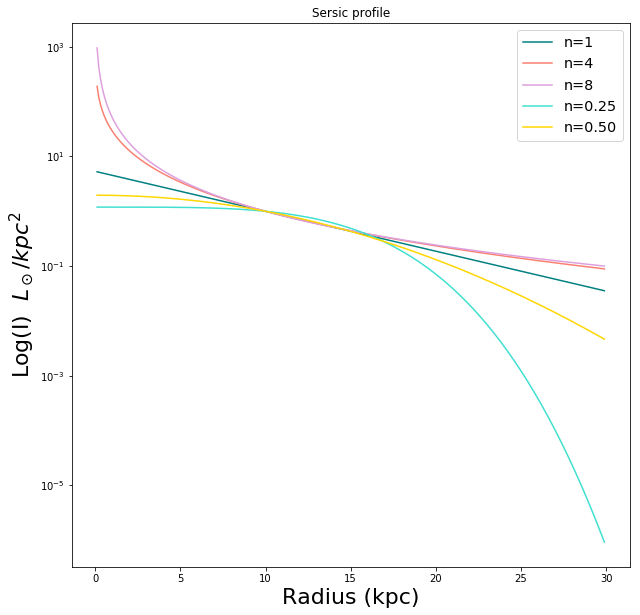

In [10]:
####### Sersic Profile ########

r = np.arange(0.1, 30, 0.1)


sm_n025 = sersic_profile(r, 1, 0.25, 10)
sm_n050 = sersic_profile(r, 1, 0.50, 10)
sm_n1 = sersic_profile(r, 1, 1, 10)
sm_n4 = sersic_profile(r, 1, 4, 10)
sm_n8 = sersic_profile(r, 1, 8, 10)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

plt.title('Sersic profile')
plt.semilogy(r, (sm_n1), '-', color='teal', label='n=1')
plt.semilogy(r, (sm_n4), '-', color='salmon', label='n=4')
plt.semilogy(r, (sm_n8), '-', color='plum', label='n=8')
plt.semilogy(r, (sm_n025), '-', color='turquoise', label='n=0.25')
plt.semilogy(r, (sm_n050), '-', color='gold', label='n=0.50')
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Log(I)  $L_\odot/kpc^2$', fontsize=22)
plt.legend(loc='upper right', fontsize = 'x-large')
plt.show()

In [11]:
# We are going to get the effective radius not form the luminosity but from the mass
# at large radius make sure L-profile  is equal to Ltot
# at 30kpc or wherever it flattens
# L_profile (r, Ie, n, Re)
# L_tot (Ie, n, Re)
# 2 figures, L_prof, color vs radius,

#############Data#########################
# Banda g del SDSS: 4770 angstroms (green)
# Magnitud Absoluta = M_g = -19.80323 magnitudes
# Radio efectivo = Re = 3.91504 kpc
# Indice de Sersic = ns = 3.6546
###########Data#########################
# Banda i del SDSS: 7625 angstroms
# Magnitud Absoluta = M_i = -20.90624 magnitudes
# Radio efectivo = Re = 4.10757 kpc
# Indice de Sersic = ns = 3.56484

In [12]:
#Test magnitude to luminosity works
print(abs_mag_to_Lx(-19.80323, 'g'))
print(abs_mag_to_Lx(-20.90624, 'i'))



21275.086090704677
26225.722947603183


In [13]:
# Sersic index
ng = 3.6546
ni = 3.56484

# Effective Radius
Rg = 3.91504
Ri = 4.10757 

# Magnitude
Mxg = -19.80323
Mxi = -20.90624

# changing magnitude to luminosity
L_g = abs_mag_to_Lx(-19.80323, 'g')
L_i = abs_mag_to_Lx(-20.90624, 'i')


print('L_g = ',L_g)
print('L_i = ',L_i)


# changing luminosity to intensity
Ie_g = Ltot_to_Ie(L_g, Rg, ng)
Ie_i = Ltot_to_Ie(L_i, Ri, ni)



print('Ie_g = ', Ie_g)
print('Ie_i = ',Ie_i)

# Making sure l_profile is equal to L_tot at large radius

LpG = L_profile(1000, Ie_g, ng, Rg)
LtG = L_tot(Ie_g, ng, Rg)
LpI = L_profile(1000, Ie_i, ni, Ri)
LtI = L_tot(Ie_i, ni, Ri)


# Testing absolute magnitude function

Mg = M_x(r, Mxg, 'g', Rg, ng)  ###### this doens't make sense
Mi = M_x(r, Mxi, 'i', Ri, ni)  ##### is this only to make it a function of radius?

# Testing "color" function

color = color(100, Mxg, Mxi, Rg, Ri, ng, ni)
print



L_g =  21275.086090704677
L_i =  26225.722947603183
Ie_g =  63.982581179032444
Ie_i =  72.51241195137757


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
LpG, LtG

In [ ]:
 LpI, LtI

In [15]:
#r= np.logspace(-2, 1.2, 50)

LpG = L_profile(r, Ie_g, ng, Rg)

LpI = L_profile(r, Ie_i, ni, Ri)


LpG= []
LpI = []
radius = np.logspace(-1, 1.2, 100)
for i in range(0, 100):
    rg.append(L_profile(radius[i], Ie_g, ng, Rg))
    ri.append(L_profile(radius[i], Ie_i, ni, Ri))

plt.title('Luminosity profile g & i band vs radius')
plt.plot(np.log10(), np.log10(radius), '-', color='blue', label='g')
plt.plot(np.log10(LpI), np.log10(radius), '-', color='red', label='i')

plt.xlabel('radius [kpc]')
plt.ylabel('Luminosity profile log($L_\odot$)')
plt.xlim(9, 12)
plt.ylim(-0.5,1.5)
plt.legend()
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [7]:
gamma(1)

1.0